In [1]:
import sys
sys.path.append('../')

import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
from scipy import stats


import os
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.proj3d import proj_transform
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d


import scienceplots
from tensorflow.python.client import device_lib

#plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_mean,reduce_euclidean_norm, sin, cos, abs
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp

from utils.utils import *
import cv2

from scipy import ndimage, fft

plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})

c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


#### Experiment #1 : Symmetric Convolution


In [2]:
'''model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))'''

"model = VGG16(weights='imagenet',\n                  include_top=False,\n                  input_shape=(224, 224, 3))"

In [3]:
k = 20 # Top 10% highest l2-magnitude filters

(3, 3, 1, 1)
(1, 3, 3, 1) (1, 3, 3, 1) (1, 3, 3, 1)


c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\ipykernel_launcher.py:35: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.


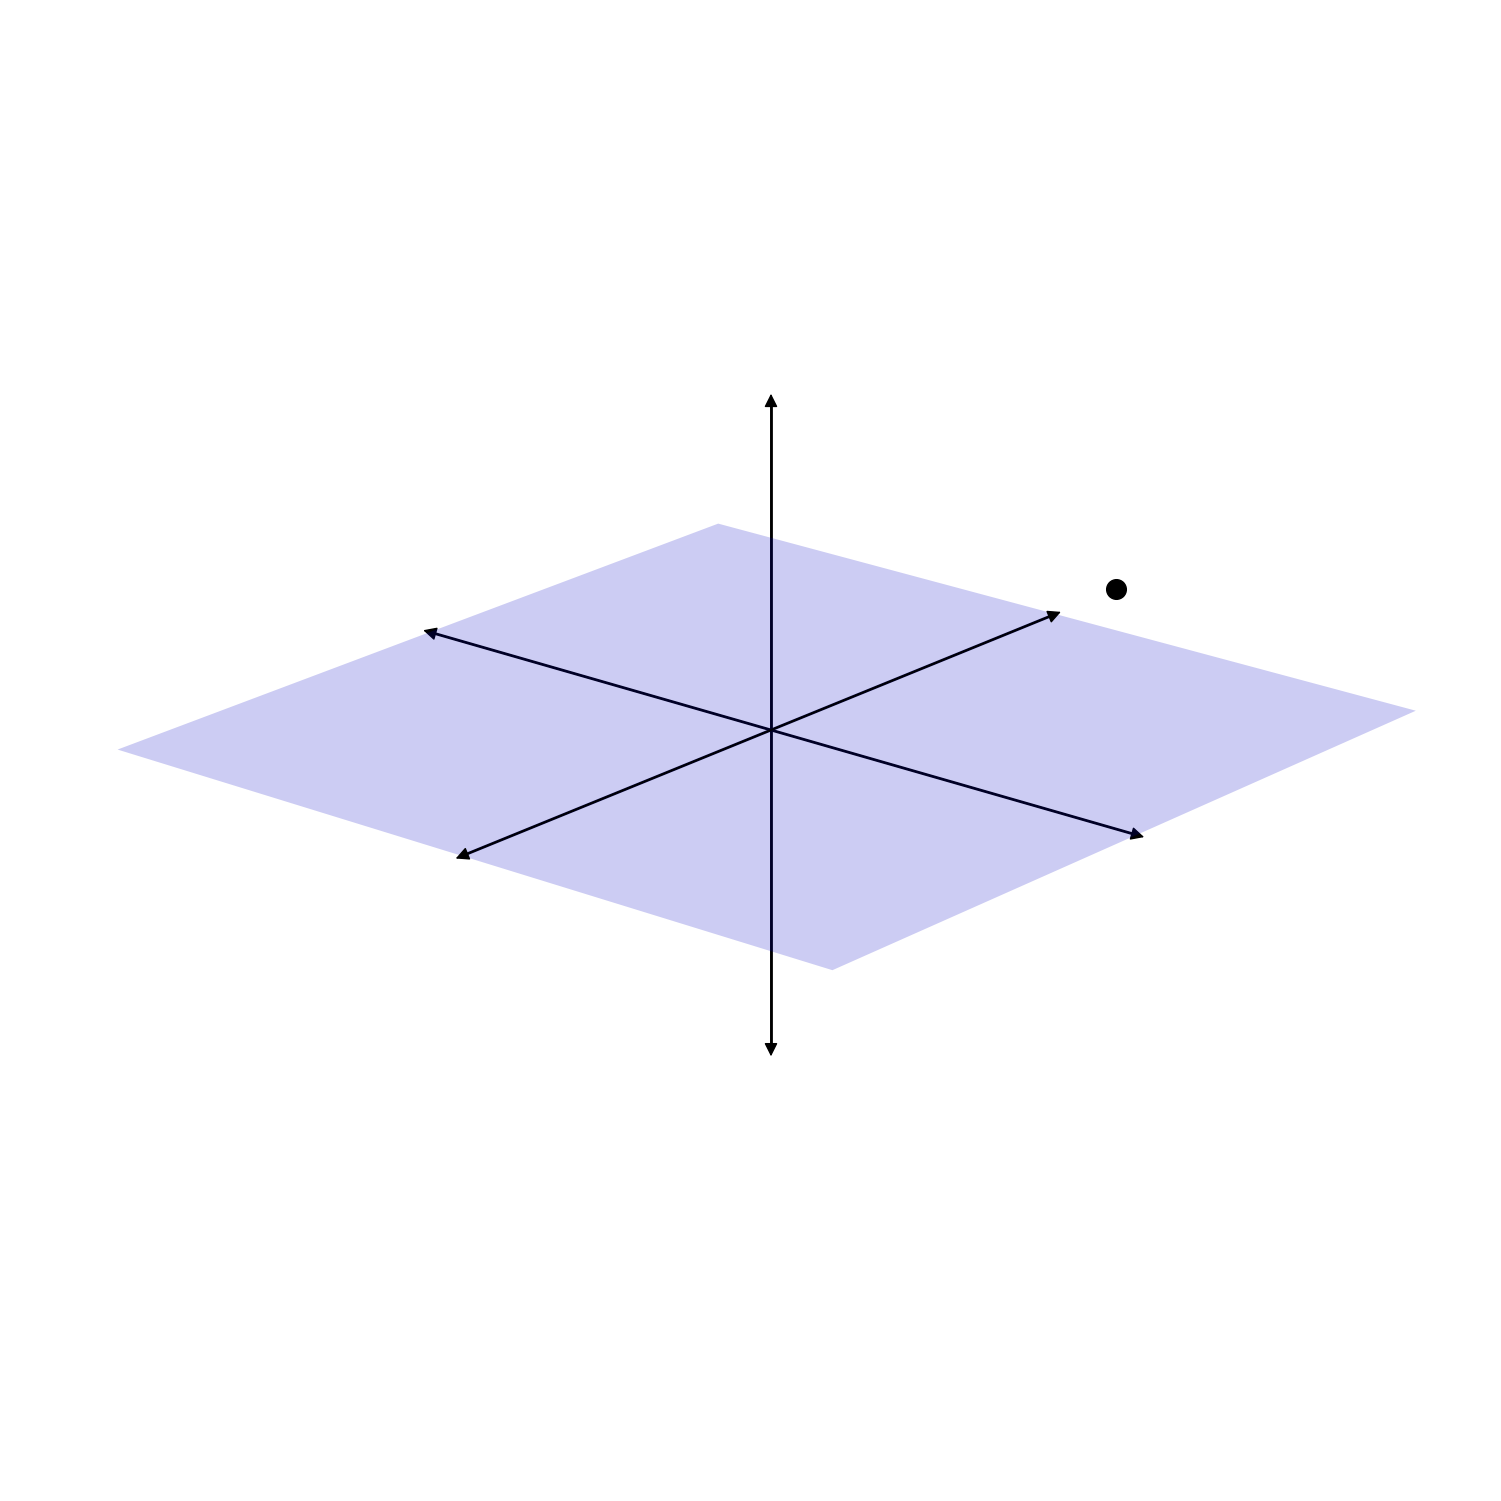

In [4]:
F = 0

filters = np.zeros((3,3,1,1))
filters[:,:,0,0] =  (1/(6))*np.array([[1,0,-1], [1,0,-1], [1,0,-1]])


theta = getSobelTF(filters)
print(filters.shape)
s, a = getSymAntiSymTF(filters)

a_mag = reduce_euclidean_norm(a, axis=[0,1])
s_mag = reduce_euclidean_norm(s, axis=[0,1])
mag = reduce_euclidean_norm(filters, axis=[0,1])


x =(a_mag[:,F]*np.cos((theta[:,F]))).numpy()
y =( a_mag[:,F]*np.sin((theta[:,F]))).numpy()
z =(s_mag[:,F]*np.sign(np.mean(s, axis=(0,1)))[:,F]).numpy()
plt.rcParams.update({'figure.dpi': '100'})


class Arrow3D(FancyArrowPatch):
	def __init__(self, xs, ys, zs, *args, **kwargs):
		super().__init__((0,0), (0,0), *args, **kwargs)
		self._verts3d = xs, ys, zs

	def do_3d_projection(self, renderer=None):
		xs3d, ys3d, zs3d = self._verts3d
		xs, ys, zs = proj_transform(xs3d, ys3d, zs3d, self.axes.M)
		self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
		return np.min(zs)

	def draw(self, renderer):
		xs3d, ys3d, zs3d = self._verts3d
		xs, ys, zs = proj_transform(xs3d, ys3d, zs3d, renderer.M)
		self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
		FancyArrowPatch.draw(self, renderer)

# Create a new figure and a 3D axis
fig = plt.figure(figsize=(15, 15),constrained_layout=True)
ax = fig.add_subplot(111, projection='3d')

# Remove the panes (walls)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Remove the pane lines
ax.xaxis.pane.set_edgecolor('none')
ax.yaxis.pane.set_edgecolor('none')
ax.zaxis.pane.set_edgecolor('none')

# Remove grid lines
ax.grid(False)

# Remove default tick marks and labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

# Create the axes lines
axis_length = 10
ax.plot([-1, 1], [0, 0], [0, 0], 'k-', linewidth=2)  # x-axis
ax.plot([0, 0], [-1, 1], [0, 0], 'k-', linewidth=2)  # y-axis
ax.plot([0, 0], [0, 0], [-1, 1], 'k-', linewidth=2)  # z-axis

# Set labels for the axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set the limits for each axis
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)

arrow_prop_dict = dict(mutation_scale=20, arrowstyle='<|-|>', shrinkA=0, shrinkB=0)


	
a = Arrow3D([- 1.02, 1.02], [0, 0], [0, 0], **arrow_prop_dict, color='k')
ax.add_artist(a)
a = Arrow3D( [0, 0],[- 1.02, 1.02], [0, 0], **arrow_prop_dict, color='k')
ax.add_artist(a)
a = Arrow3D([0, 0], [0, 0],[-1.02, 1.02], **arrow_prop_dict, color='k')
ax.add_artist(a)


# Color the x,y plane
xx, yy = np.meshgrid(range(-1, 2), range(-1, 2))
ax.plot_surface(xx, yy, np.zeros_like(xx), alpha=0.2, color='blue') 
# Add text to the x,y plane
#ax.text(0, 0, 0, "X-Y Plane", fontsize=14, ha='center', va='center', 
#        zdir='x', zorder=20)# Example: Plot some 3D points
points = np.array([x,y,z]).T*3
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='k', s=200)
plt.axis('off')
# Show the plot

ax.view_init(elev=20, azim=40)

#fig.savefig(f'hand_antisym_unipolar.pdf', dpi=600,  transparent=True, bbox_inches='tight')
plt.show()

#import subprocess
#subprocess.run(["pdfcrop ", f'hand_antisym_unipolar.pdf']) 


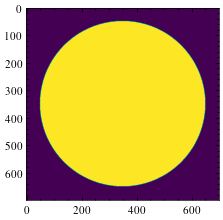

In [5]:
img = np.zeros((700, 700))
center_coordinates = (img.shape[0]//2, img.shape[1]//2) 
img = cv2.circle(img, center_coordinates, 300, (255,255,255), -1) 
plt.imshow(img)


(700, 700)


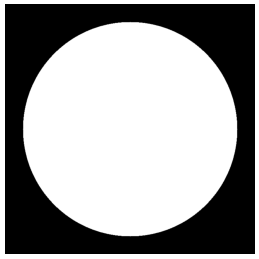

In [6]:
#var = 2/(128*9)

img =  img/255.
fig,ax = plt.subplots(1)

ax.imshow(img, cmap='gray')

#img = (img-np.mean(img))/np.std(img)
#img = tf.repeat(tf.expand_dims([img], axis=-1) , repeats = 512, axis=-1)  #get_double_slit(shape) , axis=0)
print(img.shape)
plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig("input.png",bbox_inches='tight',   pad_inches = 0)


In [49]:
w[:,:,0,0] = (np.cos(0))*np.array([[1,0,-1], [1,0,-1], [1,0,-1]]) + ( np.sin(0))*np.array([[1,1,1], [0,0,0], [-1,-1,-1]])
w[:,:,0,0] = w[:,:,0,0] / (tf.math.reduce_euclidean_norm(w[:,:,0,0])**2)
w[..., 0,0]

array([[ 0.16666667,  0.        , -0.16666667],
       [ 0.16666667,  0.        , -0.16666667],
       [ 0.16666667,  0.        , -0.16666667]])

In [44]:
import matplotlib.patches as mpatches


w = np.zeros((3,3,1,1))

w[:,:,0,0] = (np.cos(0))*np.array([[1,0,-1], [1,0,-1], [1,0,-1]]) + ( np.sin(0))*np.array([[1,1,1], [0,0,0], [-1,-1,-1]])
w[:,:,0,0] = w[:,:,0,0] / (tf.math.reduce_euclidean_norm(w[:,:,0,0])**2)

#w[:,:,0,0] = (1/(6))*np.array([[1,0,-1], [1,0,-1], [1,0,-1]])


x = img




directory = f"figures/malus"
if not os.path.exists(directory):
	os.makedirs(directory)


response_mag = []
init_mag = tf.math.reduce_euclidean_norm(x).numpy()

x = tf.cast(tf.repeat(tf.expand_dims([img], axis=-1) , repeats = filters.shape[-2], axis=-1), dtype=tf.float32) 


x = tf.nn.relu( tf.nn.conv2d(x, w , strides=(1,1), 
							 padding='SAME') )

init_mag = tf.math.reduce_euclidean_norm(x).numpy()

angles = np.linspace(-np.pi, np.pi, 100)

for i in range(100):
	print(i)
	print(x.shape)
	#fig, ax = plt.subplots()

	w[:,:,0,0] = (np.cos(angles[i]))*np.array([[1,0,-1], [1,0,-1], [1,0,-1]]) + ( np.sin(angles[i]))*np.array([[1,1,1], [0,0,0], [-1,-1,-1]])
	w[:,:,0,0] = w[:,:,0,0] / (tf.math.reduce_euclidean_norm(w[:,:,0,0])**2)

		
	x_out = tf.nn.relu( tf.nn.conv2d(x, w , strides=(1,1), 
								padding='SAME') )

	response_mag.append(tf.math.reduce_euclidean_norm(x_out).numpy()/init_mag)
	print(response_mag[-1])

	'''im = ax.imshow(np.sum(x_out[0,:,:,:], axis=-1));
	#ax.plot(45//2, 45, marker = '+', color='red');



	ax.set(xlim=(0, img.shape[0]), ylim=(0,  img.shape[1]));

	fig.colorbar(im, orientation='vertical');
	fig.savefig(directory + f'/{i}.pdf', dpi=600,  transparent=True, bbox_inches='tight')'''




0
(1, 700, 700, 1)
0.41321138
1
(1, 700, 700, 1)
0.41255233
2
(1, 700, 700, 1)
0.41057947
3
(1, 700, 700, 1)
0.4073059
4
(1, 700, 700, 1)
0.4027533
5
(1, 700, 700, 1)
0.39695278
6
(1, 700, 700, 1)
0.3899448
7
(1, 700, 700, 1)
0.38177925
8
(1, 700, 700, 1)
0.37251616
9
(1, 700, 700, 1)
0.36222628
10
(1, 700, 700, 1)
0.3509928
11
(1, 700, 700, 1)
0.3389125
12
(1, 700, 700, 1)
0.32609686
13
(1, 700, 700, 1)
0.3126752
14
(1, 700, 700, 1)
0.2987985
15
(1, 700, 700, 1)
0.2846401
16
(1, 700, 700, 1)
0.27040103
17
(1, 700, 700, 1)
0.2563186
18
(1, 700, 700, 1)
0.24266657
19
(1, 700, 700, 1)
0.22976016
20
(1, 700, 700, 1)
0.21795925
21
(1, 700, 700, 1)
0.20766126
22
(1, 700, 700, 1)
0.19927418
23
(1, 700, 700, 1)
0.19318874
24
(1, 700, 700, 1)
0.189725
25
(1, 700, 700, 1)
0.18908292
26
(1, 700, 700, 1)
0.19129807
27
(1, 700, 700, 1)
0.19623797
28
(1, 700, 700, 1)
0.20362699
29
(1, 700, 700, 1)
0.21309745
30
(1, 700, 700, 1)
0.22424315
31
(1, 700, 700, 1)
0.236662
32
(1, 700, 700, 1)
0.2499841
3

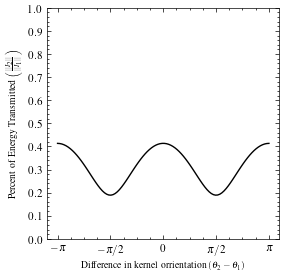

In [64]:
fig, ax= plt.subplots(1,1, figsize=(3,3))

ax.plot(angles,response_mag)

ticks = np.arange(-np.pi, 1.5*np.pi, np.pi/2)
labels = [r"$-\pi$", r"$-\pi/2$", r"$0$", r"$\pi/2$", r"$\pi$"]
# Set ticks and labels on the x-axis
ax.set_xticks(ticks=ticks, labels=labels);
ax.set_yticks(ticks=np.arange(0,1.1, 0.1));

ax.set_ylabel(r"Percent of Energy Transmitted $\left( \frac{||I_{2}||}{||I_{1}||} \right)$", fontsize=7)
ax.set_xlabel(r"Difference in kernel orrientation $(\theta_2 - \theta_1)$", fontsize=7)

plt.savefig('malus.pdf', dpi=600)
plt.show()


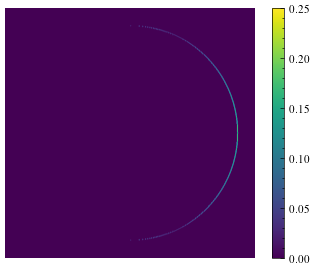

In [63]:
angle = 0
w[:,:,0,0] = (np.cos(angle))*np.array([[1,0,-1], [1,0,-1], [1,0,-1]]) + ( np.sin(angle))*np.array([[1,1,1], [0,0,0], [-1,-1,-1]])
w[:,:,0,0] = w[:,:,0,0] / (tf.math.reduce_euclidean_norm(w[:,:,0,0])**2)

i0 = tf.cast(tf.repeat(tf.expand_dims([img], axis=-1) , repeats = filters.shape[-2], axis=-1), dtype=tf.float32) 


i1 = tf.nn.relu( tf.nn.conv2d(x, w , strides=(1,1), 
							 padding='SAME') )

fig, ax= plt.subplots(1,1)

im =ax.imshow(i1[0,...,0])
#ax.plot(45//2, 45, marker = '+', color='red');



ax.set(xlim=(0, img.shape[0]), ylim=(0,  img.shape[1]));

fig.colorbar(im, orientation='vertical');

plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig("i1.pdf",bbox_inches='tight',   pad_inches = 0, dpi=600)




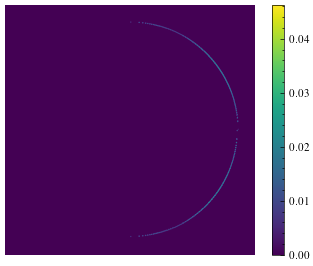

In [56]:
angle = np.pi/2
w[:,:,0,0] = (np.cos(angle))*np.array([[1,0,-1], [1,0,-1], [1,0,-1]]) + ( np.sin(angle))*np.array([[1,1,1], [0,0,0], [-1,-1,-1]])
w[:,:,0,0] = w[:,:,0,0] / (tf.math.reduce_euclidean_norm(w[:,:,0,0])**2)



i2 = tf.nn.relu( tf.nn.conv2d(i1, w , strides=(1,1), 
							 padding='SAME') )


fig, ax= plt.subplots(1,1)

im =ax.imshow(i2[0,...,0])
#ax.plot(45//2, 45, marker = '+', color='red');



ax.set(xlim=(0, img.shape[0]), ylim=(0,  img.shape[1]));

fig.colorbar(im, orientation='vertical');

plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig("i1_y.pdf",bbox_inches='tight',   pad_inches = 0, dpi=600)


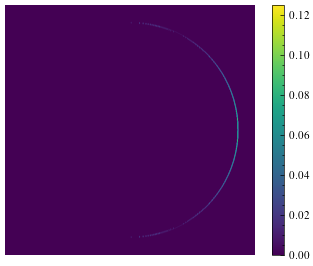

In [57]:
angle = 0
w[:,:,0,0] = (np.cos(angle))*np.array([[1,0,-1], [1,0,-1], [1,0,-1]]) + ( np.sin(angle))*np.array([[1,1,1], [0,0,0], [-1,-1,-1]])
w[:,:,0,0] = w[:,:,0,0] / (tf.math.reduce_euclidean_norm(w[:,:,0,0])**2)



i2 = tf.nn.relu( tf.nn.conv2d(i1, w , strides=(1,1), 
							 padding='SAME') )


fig, ax= plt.subplots(1,1)

im =ax.imshow(i2[0,...,0])
#ax.plot(45//2, 45, marker = '+', color='red');



ax.set(xlim=(0, img.shape[0]), ylim=(0,  img.shape[1]));

fig.colorbar(im, orientation='vertical');

plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig("i1_x.pdf",bbox_inches='tight',   pad_inches = 0, dpi=600)